In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
"""
0: background,
1: sacrum,
2: right_hip,
3: left_hip,
4: lumbar_vertebra.        
"""        

'\n0: background,\n1: sacrum,\n2: right_hip,\n3: left_hip,\n4: lumbar_vertebra.        \n'

In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    Resized,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    Activationsd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ScaleIntensityd,
    SaveImaged,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from monai.optimizers import Novograd
from monai.utils import get_torch_version_tuple, set_determinism
from ignite.handlers import EarlyStopping, ModelCheckpoint

print_config()


MONAI version: 0.9.dev2209
Numpy version: 1.21.5
Pytorch version: 1.10.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 9db6e543d6090a3256f20695c1d3224df8cbbc0e
MONAI __file__: C:\Users\Hripsime\anaconda3\envs\abys\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.1
Pillow version: 8.4.0
Tensorboard version: 2.8.0
gdown version: 4.2.1
TorchVision version: 0.11.3
tqdm version: 4.62.3
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.4.1
einops version: 0.4.0
transformers version: 4.16.2
mlflow version: 1.23.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [4]:
root_dir  = '../projects/CTPelvic1K_data/'

data_image = os.path.join(root_dir, 'images')
data_mask = os.path.join(root_dir, 'masks')


## Set dataset path

In [5]:
train_images = sorted(glob.glob(os.path.join(data_image, "*data.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_mask, "*mask_4label.nii.gz")))

data_dicts = [ {"image": image_name, "mask": label_name} for image_name, label_name in zip(train_images, train_labels) ]
train_files, val_files = data_dicts[:-10], data_dicts[-10:]

In [6]:
set_determinism(seed=0)

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image", "mask"], source_key="image"),
        #DataStatsd(keys=["image", "label"], prefix='Data', data_type=True, data_shape=True, value_range=True, data_value=False),
        
        RandCropByPosNegLabeld(
            keys=["image", "mask"],
            label_key="mask",
            spatial_size=(128, 128, 128),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        
        EnsureTyped(keys=["image", "mask"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image", "mask"], source_key="image"),
        EnsureTyped(keys=["image", "mask"]),
    ]
)



In [8]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=0)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)


Loading dataset: 100%|█████████████████████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.79s/it]


In [13]:
import gc #garbage collector
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

## Create Model, Loss, Optimizer

In [14]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer

VAL_AMP = True #Automatic mixed precision to accelerate training speed and reduce a memory usage
learning_rate = 2e-4

device=torch.device("cuda:0")     
#device=torch.device("cpu")      
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=5,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
#loss_function = DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=True, batch=True) 

optimizer = torch.optim.Adam(model.parameters(), learning_rate)
#optimizer = Novograd(model.parameters(), learning_rate * 10)
dice_metric = DiceMetric(include_background=False, reduction="mean")


# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(160, 160, 160),
            sw_batch_size=4,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)
    
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True    

## Execute a typical PyTorch training process

In [15]:
max_epochs = 400
val_interval = 1
best_metric = -1
best_metric_epoch = -1

epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=5)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=5)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["mask"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["mask"].to(device),
                )
                
                val_outputs = inference(val_inputs)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/400
1/15, train_loss: 0.9016
2/15, train_loss: 0.8979
3/15, train_loss: 0.8988
4/15, train_loss: 0.8908
5/15, train_loss: 0.8853
6/15, train_loss: 0.8776
7/15, train_loss: 0.8771
8/15, train_loss: 0.8841
9/15, train_loss: 0.8734
10/15, train_loss: 0.8703
11/15, train_loss: 0.8703
12/15, train_loss: 0.8595
13/15, train_loss: 0.8747
14/15, train_loss: 0.8630
15/15, train_loss: 0.8689
16/15, train_loss: 0.8580
epoch 1 average loss: 0.8782
saved new best metric model
current epoch: 1 current mean dice: 0.1119
best mean dice: 0.1119 at epoch: 1
----------
epoch 2/400
1/15, train_loss: 0.8588
2/15, train_loss: 0.8614
3/15, train_loss: 0.8555
4/15, train_loss: 0.8749
5/15, train_loss: 0.8602
6/15, train_loss: 0.8552
7/15, train_loss: 0.8583
8/15, train_loss: 0.8452
9/15, train_loss: 0.8439
10/15, train_loss: 0.8443
11/15, train_loss: 0.8408
12/15, train_loss: 0.8506
13/15, train_loss: 0.8278
14/15, train_loss: 0.8179
15/15, train_loss: 0.8347
16/15, train_loss: 0.8089
epoch

16/15, train_loss: 0.5711
epoch 15 average loss: 0.6016
saved new best metric model
current epoch: 15 current mean dice: 0.5487
best mean dice: 0.5487 at epoch: 15
----------
epoch 16/400
1/15, train_loss: 0.6371
2/15, train_loss: 0.5843
3/15, train_loss: 0.6255
4/15, train_loss: 0.5542
5/15, train_loss: 0.5080
6/15, train_loss: 0.5477
7/15, train_loss: 0.6511
8/15, train_loss: 0.5682
9/15, train_loss: 0.5633
10/15, train_loss: 0.6497
11/15, train_loss: 0.6531
12/15, train_loss: 0.5321
13/15, train_loss: 0.5236
14/15, train_loss: 0.5315
15/15, train_loss: 0.5641
16/15, train_loss: 0.6124
epoch 16 average loss: 0.5816
current epoch: 16 current mean dice: 0.4972
best mean dice: 0.5487 at epoch: 15
----------
epoch 17/400
1/15, train_loss: 0.6950
2/15, train_loss: 0.5006
3/15, train_loss: 0.5781
4/15, train_loss: 0.6502
5/15, train_loss: 0.5873
6/15, train_loss: 0.6004
7/15, train_loss: 0.5733
8/15, train_loss: 0.6036
9/15, train_loss: 0.5636
10/15, train_loss: 0.6722
11/15, train_loss: 0

11/15, train_loss: 0.5329
12/15, train_loss: 0.4843
13/15, train_loss: 0.3587
14/15, train_loss: 0.4995
15/15, train_loss: 0.4854
16/15, train_loss: 0.5304
epoch 30 average loss: 0.4591
current epoch: 30 current mean dice: 0.7368
best mean dice: 0.7436 at epoch: 27
----------
epoch 31/400
1/15, train_loss: 0.5260
2/15, train_loss: 0.4631
3/15, train_loss: 0.5771
4/15, train_loss: 0.4606
5/15, train_loss: 0.3745
6/15, train_loss: 0.4873
7/15, train_loss: 0.3851
8/15, train_loss: 0.4808
9/15, train_loss: 0.3711
10/15, train_loss: 0.3780
11/15, train_loss: 0.3959
12/15, train_loss: 0.4380
13/15, train_loss: 0.5281
14/15, train_loss: 0.3916
15/15, train_loss: 0.5114
16/15, train_loss: 0.3891
epoch 31 average loss: 0.4474
current epoch: 31 current mean dice: 0.7393
best mean dice: 0.7436 at epoch: 27
----------
epoch 32/400
1/15, train_loss: 0.3845
2/15, train_loss: 0.4323
3/15, train_loss: 0.4220
4/15, train_loss: 0.4970
5/15, train_loss: 0.4410
6/15, train_loss: 0.4851
7/15, train_loss: 0

9/15, train_loss: 0.4390
10/15, train_loss: 0.3378
11/15, train_loss: 0.4101
12/15, train_loss: 0.3640
13/15, train_loss: 0.3860
14/15, train_loss: 0.4332
15/15, train_loss: 0.3142
16/15, train_loss: 0.6320
epoch 45 average loss: 0.3953
saved new best metric model
current epoch: 45 current mean dice: 0.7807
best mean dice: 0.7807 at epoch: 45
----------
epoch 46/400
1/15, train_loss: 0.4051
2/15, train_loss: 0.4125
3/15, train_loss: 0.4094
4/15, train_loss: 0.3101
5/15, train_loss: 0.4721
6/15, train_loss: 0.3796
7/15, train_loss: 0.5753
8/15, train_loss: 0.3088
9/15, train_loss: 0.4543
10/15, train_loss: 0.4099
11/15, train_loss: 0.4412
12/15, train_loss: 0.3529
13/15, train_loss: 0.3220
14/15, train_loss: 0.4503
15/15, train_loss: 0.3398
16/15, train_loss: 0.3436
epoch 46 average loss: 0.3992
saved new best metric model
current epoch: 46 current mean dice: 0.7877
best mean dice: 0.7877 at epoch: 46
----------
epoch 47/400
1/15, train_loss: 0.3067
2/15, train_loss: 0.4816
3/15, train_

1/15, train_loss: 0.3037
2/15, train_loss: 0.3317
3/15, train_loss: 0.4437
4/15, train_loss: 0.2829
5/15, train_loss: 0.2155
6/15, train_loss: 0.4520
7/15, train_loss: 0.3388
8/15, train_loss: 0.3684
9/15, train_loss: 0.4225
10/15, train_loss: 0.2988
11/15, train_loss: 0.4124
12/15, train_loss: 0.2657
13/15, train_loss: 0.4598
14/15, train_loss: 0.2616
15/15, train_loss: 0.2575
16/15, train_loss: 0.3887
epoch 60 average loss: 0.3440
current epoch: 60 current mean dice: 0.8274
best mean dice: 0.8275 at epoch: 56
----------
epoch 61/400
1/15, train_loss: 0.2583
2/15, train_loss: 0.4390
3/15, train_loss: 0.4553
4/15, train_loss: 0.3208
5/15, train_loss: 0.3694
6/15, train_loss: 0.3638
7/15, train_loss: 0.5596
8/15, train_loss: 0.3566
9/15, train_loss: 0.3075
10/15, train_loss: 0.3300
11/15, train_loss: 0.4646
12/15, train_loss: 0.5247
13/15, train_loss: 0.3461
14/15, train_loss: 0.4355
15/15, train_loss: 0.3681
16/15, train_loss: 0.3855
epoch 61 average loss: 0.3928
current epoch: 61 curr

1/15, train_loss: 0.3549
2/15, train_loss: 0.3353
3/15, train_loss: 0.3304
4/15, train_loss: 0.3106
5/15, train_loss: 0.3557
6/15, train_loss: 0.5101
7/15, train_loss: 0.2929
8/15, train_loss: 0.2025
9/15, train_loss: 0.3668
10/15, train_loss: 0.4100
11/15, train_loss: 0.4159
12/15, train_loss: 0.2942
13/15, train_loss: 0.2509
14/15, train_loss: 0.4159
15/15, train_loss: 0.3824
16/15, train_loss: 0.6402
epoch 75 average loss: 0.3668
current epoch: 75 current mean dice: 0.9055
best mean dice: 0.9127 at epoch: 73
----------
epoch 76/400
1/15, train_loss: 0.3524
2/15, train_loss: 0.3011
3/15, train_loss: 0.3227
4/15, train_loss: 0.4204
5/15, train_loss: 0.2436
6/15, train_loss: 0.4386
7/15, train_loss: 0.3245
8/15, train_loss: 0.3377
9/15, train_loss: 0.4965
10/15, train_loss: 0.1939
11/15, train_loss: 0.2935
12/15, train_loss: 0.4850
13/15, train_loss: 0.2751
14/15, train_loss: 0.3221
15/15, train_loss: 0.3246
16/15, train_loss: 0.2524
epoch 76 average loss: 0.3365
current epoch: 76 curr

2/15, train_loss: 0.2880
3/15, train_loss: 0.2941
4/15, train_loss: 0.3499
5/15, train_loss: 0.2754
6/15, train_loss: 0.3348
7/15, train_loss: 0.3154
8/15, train_loss: 0.3458
9/15, train_loss: 0.3928
10/15, train_loss: 0.3581
11/15, train_loss: 0.4558
12/15, train_loss: 0.3241
13/15, train_loss: 0.4401
14/15, train_loss: 0.3907
15/15, train_loss: 0.2259
16/15, train_loss: 0.3593
epoch 90 average loss: 0.3405
saved new best metric model
current epoch: 90 current mean dice: 0.9322
best mean dice: 0.9322 at epoch: 90
----------
epoch 91/400
1/15, train_loss: 0.3225
2/15, train_loss: 0.2706
3/15, train_loss: 0.2604
4/15, train_loss: 0.2728
5/15, train_loss: 0.3488
6/15, train_loss: 0.4499
7/15, train_loss: 0.2247
8/15, train_loss: 0.3316
9/15, train_loss: 0.2805
10/15, train_loss: 0.3875
11/15, train_loss: 0.4115
12/15, train_loss: 0.3348
13/15, train_loss: 0.2837
14/15, train_loss: 0.3254
15/15, train_loss: 0.3539
16/15, train_loss: 0.2666
epoch 91 average loss: 0.3203
current epoch: 91 c

1/15, train_loss: 0.2465
2/15, train_loss: 0.3460
3/15, train_loss: 0.4138
4/15, train_loss: 0.3328
5/15, train_loss: 0.3123
6/15, train_loss: 0.3630
7/15, train_loss: 0.2924
8/15, train_loss: 0.2390
9/15, train_loss: 0.3146
10/15, train_loss: 0.2836
11/15, train_loss: 0.2364
12/15, train_loss: 0.3259
13/15, train_loss: 0.3367
14/15, train_loss: 0.3377
15/15, train_loss: 0.3066
16/15, train_loss: 0.4304
epoch 105 average loss: 0.3199
current epoch: 105 current mean dice: 0.9401
best mean dice: 0.9436 at epoch: 102
----------
epoch 106/400
1/15, train_loss: 0.3514
2/15, train_loss: 0.3104
3/15, train_loss: 0.3565
4/15, train_loss: 0.4111
5/15, train_loss: 0.2905
6/15, train_loss: 0.3512
7/15, train_loss: 0.3351
8/15, train_loss: 0.1909
9/15, train_loss: 0.2454
10/15, train_loss: 0.3629
11/15, train_loss: 0.4083
12/15, train_loss: 0.4710
13/15, train_loss: 0.2676
14/15, train_loss: 0.3210
15/15, train_loss: 0.3311
16/15, train_loss: 0.2683
epoch 106 average loss: 0.3296
saved new best me

current epoch: 119 current mean dice: 0.9402
best mean dice: 0.9500 at epoch: 111
----------
epoch 120/400
1/15, train_loss: 0.3321
2/15, train_loss: 0.2814
3/15, train_loss: 0.3470
4/15, train_loss: 0.2472
5/15, train_loss: 0.3374
6/15, train_loss: 0.3784
7/15, train_loss: 0.3650
8/15, train_loss: 0.2420
9/15, train_loss: 0.2693
10/15, train_loss: 0.3687
11/15, train_loss: 0.1605
12/15, train_loss: 0.3388
13/15, train_loss: 0.4468
14/15, train_loss: 0.3670
15/15, train_loss: 0.3935
16/15, train_loss: 0.3297
epoch 120 average loss: 0.3253
saved new best metric model
current epoch: 120 current mean dice: 0.9518
best mean dice: 0.9518 at epoch: 120
----------
epoch 121/400
1/15, train_loss: 0.3635
2/15, train_loss: 0.2402
3/15, train_loss: 0.5335
4/15, train_loss: 0.3319
5/15, train_loss: 0.3569
6/15, train_loss: 0.3288
7/15, train_loss: 0.2826
8/15, train_loss: 0.3282
9/15, train_loss: 0.3440
10/15, train_loss: 0.3045
11/15, train_loss: 0.2407
12/15, train_loss: 0.2728
13/15, train_loss

current epoch: 134 current mean dice: 0.9451
best mean dice: 0.9518 at epoch: 120
----------
epoch 135/400
1/15, train_loss: 0.2764
2/15, train_loss: 0.3331
3/15, train_loss: 0.3551
4/15, train_loss: 0.3241
5/15, train_loss: 0.3804
6/15, train_loss: 0.5074
7/15, train_loss: 0.3504
8/15, train_loss: 0.3120
9/15, train_loss: 0.4302
10/15, train_loss: 0.3576
11/15, train_loss: 0.4168
12/15, train_loss: 0.3825
13/15, train_loss: 0.2428
14/15, train_loss: 0.3520
15/15, train_loss: 0.3595
16/15, train_loss: 0.2872
epoch 135 average loss: 0.3542
current epoch: 135 current mean dice: 0.9486
best mean dice: 0.9518 at epoch: 120
----------
epoch 136/400
1/15, train_loss: 0.4061
2/15, train_loss: 0.2825
3/15, train_loss: 0.2756
4/15, train_loss: 0.4700
5/15, train_loss: 0.3290
6/15, train_loss: 0.5006
7/15, train_loss: 0.3607
8/15, train_loss: 0.3316
9/15, train_loss: 0.3175
10/15, train_loss: 0.3103
11/15, train_loss: 0.5187
12/15, train_loss: 0.4079
13/15, train_loss: 0.3780
14/15, train_loss: 

16/15, train_loss: 0.3470
epoch 149 average loss: 0.3500
current epoch: 149 current mean dice: 0.9478
best mean dice: 0.9534 at epoch: 148
----------
epoch 150/400
1/15, train_loss: 0.4124
2/15, train_loss: 0.3503
3/15, train_loss: 0.3388
4/15, train_loss: 0.2716
5/15, train_loss: 0.3909
6/15, train_loss: 0.2126
7/15, train_loss: 0.2461
8/15, train_loss: 0.2938
9/15, train_loss: 0.2913
10/15, train_loss: 0.3597
11/15, train_loss: 0.2319
12/15, train_loss: 0.3753
13/15, train_loss: 0.3619
14/15, train_loss: 0.3723
15/15, train_loss: 0.3356
16/15, train_loss: 0.2765
epoch 150 average loss: 0.3200
current epoch: 150 current mean dice: 0.9430
best mean dice: 0.9534 at epoch: 148
----------
epoch 151/400
1/15, train_loss: 0.2280
2/15, train_loss: 0.3880
3/15, train_loss: 0.4780
4/15, train_loss: 0.2810
5/15, train_loss: 0.3260
6/15, train_loss: 0.3223
7/15, train_loss: 0.2871
8/15, train_loss: 0.3767
9/15, train_loss: 0.3537
10/15, train_loss: 0.3127
11/15, train_loss: 0.3574
12/15, train_l

16/15, train_loss: 0.2855
epoch 164 average loss: 0.3293
current epoch: 164 current mean dice: 0.9526
best mean dice: 0.9580 at epoch: 155
----------
epoch 165/400
1/15, train_loss: 0.3534
2/15, train_loss: 0.3126
3/15, train_loss: 0.2625
4/15, train_loss: 0.4289
5/15, train_loss: 0.3940
6/15, train_loss: 0.3262
7/15, train_loss: 0.3234
8/15, train_loss: 0.1807
9/15, train_loss: 0.3831
10/15, train_loss: 0.3146
11/15, train_loss: 0.2907
12/15, train_loss: 0.3096
13/15, train_loss: 0.4425
14/15, train_loss: 0.3475
15/15, train_loss: 0.4027
16/15, train_loss: 0.3298
epoch 165 average loss: 0.3376
current epoch: 165 current mean dice: 0.9488
best mean dice: 0.9580 at epoch: 155
----------
epoch 166/400
1/15, train_loss: 0.3199
2/15, train_loss: 0.3450
3/15, train_loss: 0.3196
4/15, train_loss: 0.4333
5/15, train_loss: 0.4518
6/15, train_loss: 0.3013
7/15, train_loss: 0.2405
8/15, train_loss: 0.4472
9/15, train_loss: 0.3026
10/15, train_loss: 0.3560
11/15, train_loss: 0.2892
12/15, train_l

16/15, train_loss: 0.2953
epoch 179 average loss: 0.3577
current epoch: 179 current mean dice: 0.9514
best mean dice: 0.9587 at epoch: 173
----------
epoch 180/400
1/15, train_loss: 0.2744
2/15, train_loss: 0.2362
3/15, train_loss: 0.3785
4/15, train_loss: 0.3243
5/15, train_loss: 0.3399
6/15, train_loss: 0.1511
7/15, train_loss: 0.3421
8/15, train_loss: 0.3249
9/15, train_loss: 0.2808
10/15, train_loss: 0.4856
11/15, train_loss: 0.2756
12/15, train_loss: 0.2194
13/15, train_loss: 0.3012
14/15, train_loss: 0.3752
15/15, train_loss: 0.5551
16/15, train_loss: 0.3191
epoch 180 average loss: 0.3240
current epoch: 180 current mean dice: 0.9421
best mean dice: 0.9587 at epoch: 173
----------
epoch 181/400
1/15, train_loss: 0.3675
2/15, train_loss: 0.3559
3/15, train_loss: 0.3651
4/15, train_loss: 0.3525
5/15, train_loss: 0.2925
6/15, train_loss: 0.2754
7/15, train_loss: 0.2852
8/15, train_loss: 0.2799
9/15, train_loss: 0.3006
10/15, train_loss: 0.2280
11/15, train_loss: 0.4990
12/15, train_l

current epoch: 194 current mean dice: 0.9585
best mean dice: 0.9587 at epoch: 173
----------
epoch 195/400
1/15, train_loss: 0.3790
2/15, train_loss: 0.3249
3/15, train_loss: 0.3041
4/15, train_loss: 0.1898
5/15, train_loss: 0.4046
6/15, train_loss: 0.3766
7/15, train_loss: 0.2521
8/15, train_loss: 0.3328
9/15, train_loss: 0.3044
10/15, train_loss: 0.2124
11/15, train_loss: 0.3137
12/15, train_loss: 0.3763
13/15, train_loss: 0.3065
14/15, train_loss: 0.3761
15/15, train_loss: 0.2860
16/15, train_loss: 0.1802
epoch 195 average loss: 0.3075
current epoch: 195 current mean dice: 0.9586
best mean dice: 0.9587 at epoch: 173
----------
epoch 196/400
1/15, train_loss: 0.2351
2/15, train_loss: 0.3286
3/15, train_loss: 0.1838
4/15, train_loss: 0.4087
5/15, train_loss: 0.3261
6/15, train_loss: 0.3504
7/15, train_loss: 0.3288
8/15, train_loss: 0.3988
9/15, train_loss: 0.3476
10/15, train_loss: 0.2847
11/15, train_loss: 0.2627
12/15, train_loss: 0.3102
13/15, train_loss: 0.4191
14/15, train_loss: 

current epoch: 209 current mean dice: 0.9560
best mean dice: 0.9599 at epoch: 199
----------
epoch 210/400
1/15, train_loss: 0.3938
2/15, train_loss: 0.4653
3/15, train_loss: 0.3264
4/15, train_loss: 0.2648
5/15, train_loss: 0.4456
6/15, train_loss: 0.2355
7/15, train_loss: 0.2978
8/15, train_loss: 0.3279
9/15, train_loss: 0.2560
10/15, train_loss: 0.3191
11/15, train_loss: 0.2968
12/15, train_loss: 0.2308
13/15, train_loss: 0.2369
14/15, train_loss: 0.3679
15/15, train_loss: 0.4511
16/15, train_loss: 0.3726
epoch 210 average loss: 0.3305
current epoch: 210 current mean dice: 0.9596
best mean dice: 0.9599 at epoch: 199
----------
epoch 211/400
1/15, train_loss: 0.2524
2/15, train_loss: 0.1892
3/15, train_loss: 0.3721
4/15, train_loss: 0.3017
5/15, train_loss: 0.2504
6/15, train_loss: 0.3049
7/15, train_loss: 0.2469
8/15, train_loss: 0.3534
9/15, train_loss: 0.2553
10/15, train_loss: 0.4040
11/15, train_loss: 0.2891
12/15, train_loss: 0.2257
13/15, train_loss: 0.2805
14/15, train_loss: 

current epoch: 224 current mean dice: 0.9590
best mean dice: 0.9621 at epoch: 213
----------
epoch 225/400
1/15, train_loss: 0.3951
2/15, train_loss: 0.2351
3/15, train_loss: 0.3533
4/15, train_loss: 0.2531
5/15, train_loss: 0.4591
6/15, train_loss: 0.3714
7/15, train_loss: 0.3527
8/15, train_loss: 0.1811
9/15, train_loss: 0.4364
10/15, train_loss: 0.3836
11/15, train_loss: 0.2326
12/15, train_loss: 0.3321
13/15, train_loss: 0.3866
14/15, train_loss: 0.3179
15/15, train_loss: 0.2339
16/15, train_loss: 0.3174
epoch 225 average loss: 0.3276
current epoch: 225 current mean dice: 0.9609
best mean dice: 0.9621 at epoch: 213
----------
epoch 226/400
1/15, train_loss: 0.2377
2/15, train_loss: 0.3958
3/15, train_loss: 0.3887
4/15, train_loss: 0.4667
5/15, train_loss: 0.3546
6/15, train_loss: 0.3468
7/15, train_loss: 0.2837
8/15, train_loss: 0.3505
9/15, train_loss: 0.4400
10/15, train_loss: 0.3316
11/15, train_loss: 0.3005
12/15, train_loss: 0.2287
13/15, train_loss: 0.3119
14/15, train_loss: 

1/15, train_loss: 0.2196
2/15, train_loss: 0.2739
3/15, train_loss: 0.3303
4/15, train_loss: 0.4004
5/15, train_loss: 0.3008
6/15, train_loss: 0.3747
7/15, train_loss: 0.3774
8/15, train_loss: 0.3263
9/15, train_loss: 0.3484
10/15, train_loss: 0.2529
11/15, train_loss: 0.3048
12/15, train_loss: 0.2843
13/15, train_loss: 0.4078
14/15, train_loss: 0.4265
15/15, train_loss: 0.3912
16/15, train_loss: 0.3272
epoch 240 average loss: 0.3341
current epoch: 240 current mean dice: 0.9595
best mean dice: 0.9621 at epoch: 213
----------
epoch 241/400
1/15, train_loss: 0.2927
2/15, train_loss: 0.3474
3/15, train_loss: 0.2643
4/15, train_loss: 0.2886
5/15, train_loss: 0.2960
6/15, train_loss: 0.4274
7/15, train_loss: 0.3617
8/15, train_loss: 0.3320
9/15, train_loss: 0.4104
10/15, train_loss: 0.3014
11/15, train_loss: 0.2730
12/15, train_loss: 0.3325
13/15, train_loss: 0.2739
14/15, train_loss: 0.2838
15/15, train_loss: 0.2265
16/15, train_loss: 0.3701
epoch 241 average loss: 0.3176
current epoch: 24

2/15, train_loss: 0.3223
3/15, train_loss: 0.2992
4/15, train_loss: 0.4419
5/15, train_loss: 0.4800
6/15, train_loss: 0.3067
7/15, train_loss: 0.2702
8/15, train_loss: 0.2521
9/15, train_loss: 0.4483
10/15, train_loss: 0.3227
11/15, train_loss: 0.3148
12/15, train_loss: 0.2174
13/15, train_loss: 0.3848
14/15, train_loss: 0.4070
15/15, train_loss: 0.2581
16/15, train_loss: 0.5680
epoch 255 average loss: 0.3608
current epoch: 255 current mean dice: 0.9400
best mean dice: 0.9621 at epoch: 213
----------
epoch 256/400
1/15, train_loss: 0.3339
2/15, train_loss: 0.4202
3/15, train_loss: 0.3942
4/15, train_loss: 0.3143
5/15, train_loss: 0.4030
6/15, train_loss: 0.3310
7/15, train_loss: 0.3275
8/15, train_loss: 0.3865
9/15, train_loss: 0.2843
10/15, train_loss: 0.3666
11/15, train_loss: 0.3594
12/15, train_loss: 0.3402
13/15, train_loss: 0.3369
14/15, train_loss: 0.2784
15/15, train_loss: 0.4317
16/15, train_loss: 0.3560
epoch 256 average loss: 0.3540
current epoch: 256 current mean dice: 0.95

3/15, train_loss: 0.2517
4/15, train_loss: 0.3539
5/15, train_loss: 0.3847
6/15, train_loss: 0.3456
7/15, train_loss: 0.3479
8/15, train_loss: 0.3737
9/15, train_loss: 0.3917
10/15, train_loss: 0.3195
11/15, train_loss: 0.4539
12/15, train_loss: 0.2995
13/15, train_loss: 0.2901
14/15, train_loss: 0.3214
15/15, train_loss: 0.2114
16/15, train_loss: 0.4059
epoch 270 average loss: 0.3367
current epoch: 270 current mean dice: 0.9594
best mean dice: 0.9621 at epoch: 213
----------
epoch 271/400
1/15, train_loss: 0.3163
2/15, train_loss: 0.2719
3/15, train_loss: 0.4644
4/15, train_loss: 0.3813
5/15, train_loss: 0.2998
6/15, train_loss: 0.2468
7/15, train_loss: 0.3104
8/15, train_loss: 0.2847
9/15, train_loss: 0.3885
10/15, train_loss: 0.3035
11/15, train_loss: 0.4157
12/15, train_loss: 0.3634
13/15, train_loss: 0.2619
14/15, train_loss: 0.3200
15/15, train_loss: 0.3497
16/15, train_loss: 0.2762
epoch 271 average loss: 0.3284
current epoch: 271 current mean dice: 0.9596
best mean dice: 0.9621

1/15, train_loss: 0.4815
2/15, train_loss: 0.3347
3/15, train_loss: 0.2334
4/15, train_loss: 0.3569
5/15, train_loss: 0.3196
6/15, train_loss: 0.3648
7/15, train_loss: 0.2395
8/15, train_loss: 0.2731
9/15, train_loss: 0.3461
10/15, train_loss: 0.3162
11/15, train_loss: 0.3764
12/15, train_loss: 0.4041
13/15, train_loss: 0.2581
14/15, train_loss: 0.4249
15/15, train_loss: 0.1887
16/15, train_loss: 0.3205
epoch 285 average loss: 0.3274
current epoch: 285 current mean dice: 0.9584
best mean dice: 0.9635 at epoch: 278
----------
epoch 286/400
1/15, train_loss: 0.2289
2/15, train_loss: 0.3439
3/15, train_loss: 0.2910
4/15, train_loss: 0.3966
5/15, train_loss: 0.2790
6/15, train_loss: 0.2910
7/15, train_loss: 0.3675
8/15, train_loss: 0.3488
9/15, train_loss: 0.3350
10/15, train_loss: 0.4825
11/15, train_loss: 0.3844
12/15, train_loss: 0.2640
13/15, train_loss: 0.4356
14/15, train_loss: 0.4177
15/15, train_loss: 0.2633
16/15, train_loss: 0.1308
epoch 286 average loss: 0.3287
current epoch: 28

2/15, train_loss: 0.2044
3/15, train_loss: 0.3703
4/15, train_loss: 0.3952
5/15, train_loss: 0.3790
6/15, train_loss: 0.3467
7/15, train_loss: 0.3309
8/15, train_loss: 0.4041
9/15, train_loss: 0.3377
10/15, train_loss: 0.3580
11/15, train_loss: 0.2312
12/15, train_loss: 0.3324
13/15, train_loss: 0.2988
14/15, train_loss: 0.3708
15/15, train_loss: 0.2742
16/15, train_loss: 0.3823
epoch 300 average loss: 0.3370
current epoch: 300 current mean dice: 0.9609
best mean dice: 0.9635 at epoch: 278
----------
epoch 301/400
1/15, train_loss: 0.1888
2/15, train_loss: 0.3254
3/15, train_loss: 0.3944
4/15, train_loss: 0.3743
5/15, train_loss: 0.3874
6/15, train_loss: 0.3261
7/15, train_loss: 0.3160
8/15, train_loss: 0.2634
9/15, train_loss: 0.2934
10/15, train_loss: 0.3663
11/15, train_loss: 0.2504
12/15, train_loss: 0.3227
13/15, train_loss: 0.3082
14/15, train_loss: 0.2749
15/15, train_loss: 0.2000
16/15, train_loss: 0.1847
epoch 301 average loss: 0.2985
current epoch: 301 current mean dice: 0.96

2/15, train_loss: 0.3057
3/15, train_loss: 0.3697
4/15, train_loss: 0.3057
5/15, train_loss: 0.3760
6/15, train_loss: 0.2836
7/15, train_loss: 0.2208
8/15, train_loss: 0.3242
9/15, train_loss: 0.3298
10/15, train_loss: 0.3017
11/15, train_loss: 0.2772
12/15, train_loss: 0.3447
13/15, train_loss: 0.2698
14/15, train_loss: 0.3762
15/15, train_loss: 0.2917
16/15, train_loss: 0.2681
epoch 315 average loss: 0.3109
current epoch: 315 current mean dice: 0.9614
best mean dice: 0.9641 at epoch: 312
----------
epoch 316/400
1/15, train_loss: 0.1847
2/15, train_loss: 0.3327
3/15, train_loss: 0.2525
4/15, train_loss: 0.1549
5/15, train_loss: 0.3532
6/15, train_loss: 0.4238
7/15, train_loss: 0.3343
8/15, train_loss: 0.3829
9/15, train_loss: 0.2753
10/15, train_loss: 0.3466
11/15, train_loss: 0.3835
12/15, train_loss: 0.2518
13/15, train_loss: 0.3530
14/15, train_loss: 0.2230
15/15, train_loss: 0.2596
16/15, train_loss: 0.4873
epoch 316 average loss: 0.3124
current epoch: 316 current mean dice: 0.96

3/15, train_loss: 0.3191
4/15, train_loss: 0.4027
5/15, train_loss: 0.2852
6/15, train_loss: 0.4031
7/15, train_loss: 0.3139
8/15, train_loss: 0.3954
9/15, train_loss: 0.3302
10/15, train_loss: 0.2761
11/15, train_loss: 0.3295
12/15, train_loss: 0.3931
13/15, train_loss: 0.3390
14/15, train_loss: 0.2744
15/15, train_loss: 0.3090
16/15, train_loss: 0.4148
epoch 330 average loss: 0.3489
current epoch: 330 current mean dice: 0.9509
best mean dice: 0.9641 at epoch: 312
----------
epoch 331/400
1/15, train_loss: 0.3976
2/15, train_loss: 0.3378
3/15, train_loss: 0.2715
4/15, train_loss: 0.3239
5/15, train_loss: 0.4203
6/15, train_loss: 0.2568
7/15, train_loss: 0.3562
8/15, train_loss: 0.3444
9/15, train_loss: 0.4209
10/15, train_loss: 0.3517
11/15, train_loss: 0.3340
12/15, train_loss: 0.2216
13/15, train_loss: 0.2248
14/15, train_loss: 0.1635
15/15, train_loss: 0.3564
16/15, train_loss: 0.1908
epoch 331 average loss: 0.3108
current epoch: 331 current mean dice: 0.9476
best mean dice: 0.9641

4/15, train_loss: 0.3244
5/15, train_loss: 0.2782
6/15, train_loss: 0.3556
7/15, train_loss: 0.4768
8/15, train_loss: 0.1828
9/15, train_loss: 0.3370
10/15, train_loss: 0.2256
11/15, train_loss: 0.3226
12/15, train_loss: 0.3085
13/15, train_loss: 0.2969
14/15, train_loss: 0.4097
15/15, train_loss: 0.2366
16/15, train_loss: 0.3234
epoch 345 average loss: 0.3063
current epoch: 345 current mean dice: 0.9615
best mean dice: 0.9641 at epoch: 312
----------
epoch 346/400
1/15, train_loss: 0.3592
2/15, train_loss: 0.3222
3/15, train_loss: 0.3476
4/15, train_loss: 0.2990
5/15, train_loss: 0.3213
6/15, train_loss: 0.3080
7/15, train_loss: 0.3410
8/15, train_loss: 0.2694
9/15, train_loss: 0.4291
10/15, train_loss: 0.3992
11/15, train_loss: 0.2803
12/15, train_loss: 0.2957
13/15, train_loss: 0.2122
14/15, train_loss: 0.3645
15/15, train_loss: 0.2223
16/15, train_loss: 0.3348
epoch 346 average loss: 0.3191
current epoch: 346 current mean dice: 0.9603
best mean dice: 0.9641 at epoch: 312
----------

4/15, train_loss: 0.3733
5/15, train_loss: 0.3056
6/15, train_loss: 0.2955
7/15, train_loss: 0.2737
8/15, train_loss: 0.3302
9/15, train_loss: 0.4639
10/15, train_loss: 0.4011
11/15, train_loss: 0.1519
12/15, train_loss: 0.4197
13/15, train_loss: 0.3208
14/15, train_loss: 0.3907
15/15, train_loss: 0.4464
16/15, train_loss: 0.1249
epoch 360 average loss: 0.3199
current epoch: 360 current mean dice: 0.9624
best mean dice: 0.9641 at epoch: 352
----------
epoch 361/400
1/15, train_loss: 0.3193
2/15, train_loss: 0.3668
3/15, train_loss: 0.2994
4/15, train_loss: 0.2758
5/15, train_loss: 0.3202
6/15, train_loss: 0.2561
7/15, train_loss: 0.4046
8/15, train_loss: 0.3937
9/15, train_loss: 0.3717
10/15, train_loss: 0.3407
11/15, train_loss: 0.2461
12/15, train_loss: 0.1851
13/15, train_loss: 0.3178
14/15, train_loss: 0.3322
15/15, train_loss: 0.2414
16/15, train_loss: 0.1301
epoch 361 average loss: 0.3001
current epoch: 361 current mean dice: 0.9617
best mean dice: 0.9641 at epoch: 352
----------

4/15, train_loss: 0.3808
5/15, train_loss: 0.2329
6/15, train_loss: 0.3202
7/15, train_loss: 0.2433
8/15, train_loss: 0.3267
9/15, train_loss: 0.2267
10/15, train_loss: 0.3015
11/15, train_loss: 0.2518
12/15, train_loss: 0.3211
13/15, train_loss: 0.3723
14/15, train_loss: 0.2462
15/15, train_loss: 0.3616
16/15, train_loss: 0.4175
epoch 375 average loss: 0.3124
current epoch: 375 current mean dice: 0.9643
best mean dice: 0.9654 at epoch: 369
----------
epoch 376/400
1/15, train_loss: 0.3448
2/15, train_loss: 0.4017
3/15, train_loss: 0.2789
4/15, train_loss: 0.4140
5/15, train_loss: 0.2147
6/15, train_loss: 0.3453
7/15, train_loss: 0.3029
8/15, train_loss: 0.2247
9/15, train_loss: 0.3430
10/15, train_loss: 0.2736
11/15, train_loss: 0.3269
12/15, train_loss: 0.3687
13/15, train_loss: 0.3343
14/15, train_loss: 0.3059
15/15, train_loss: 0.3843
16/15, train_loss: 0.4749
epoch 376 average loss: 0.3337
saved new best metric model
current epoch: 376 current mean dice: 0.9655
best mean dice: 0.9

4/15, train_loss: 0.3735
5/15, train_loss: 0.3256
6/15, train_loss: 0.3165
7/15, train_loss: 0.3454
8/15, train_loss: 0.4140
9/15, train_loss: 0.2508
10/15, train_loss: 0.3258
11/15, train_loss: 0.3923
12/15, train_loss: 0.3229
13/15, train_loss: 0.3559
14/15, train_loss: 0.3803
15/15, train_loss: 0.2982
16/15, train_loss: 0.2211
epoch 390 average loss: 0.3293
current epoch: 390 current mean dice: 0.9632
best mean dice: 0.9655 at epoch: 376
----------
epoch 391/400
1/15, train_loss: 0.3230
2/15, train_loss: 0.3547
3/15, train_loss: 0.2981
4/15, train_loss: 0.2910
5/15, train_loss: 0.3655
6/15, train_loss: 0.3977
7/15, train_loss: 0.3634
8/15, train_loss: 0.3088
9/15, train_loss: 0.2279
10/15, train_loss: 0.3937
11/15, train_loss: 0.2616
12/15, train_loss: 0.2424
13/15, train_loss: 0.2351
14/15, train_loss: 0.2203
15/15, train_loss: 0.2774
16/15, train_loss: 0.1793
epoch 391 average loss: 0.2962
saved new best metric model
current epoch: 391 current mean dice: 0.9656
best mean dice: 0.9

In [16]:
#400 epochs run 150 minutes (2 hours 30 minutes) (1 epoch = 0.38 minute)

In [17]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9656 at epoch: 391


## Plot the loss and metric

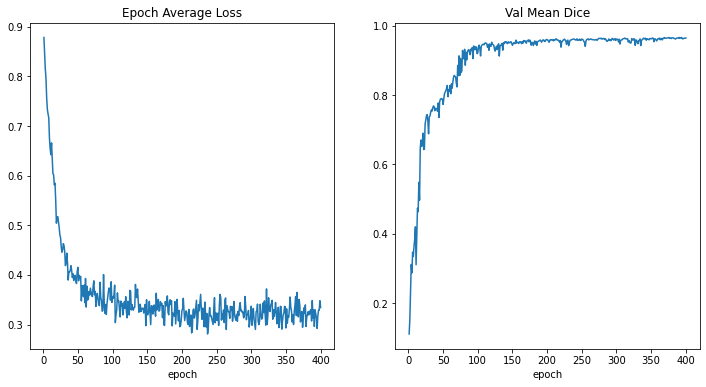

In [18]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

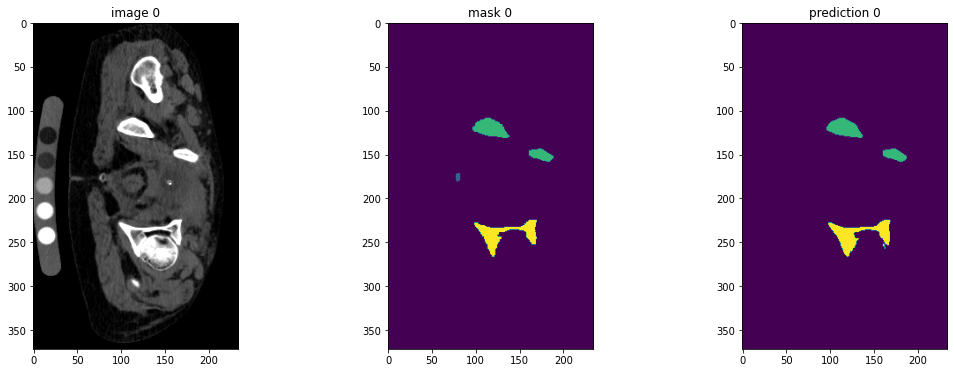

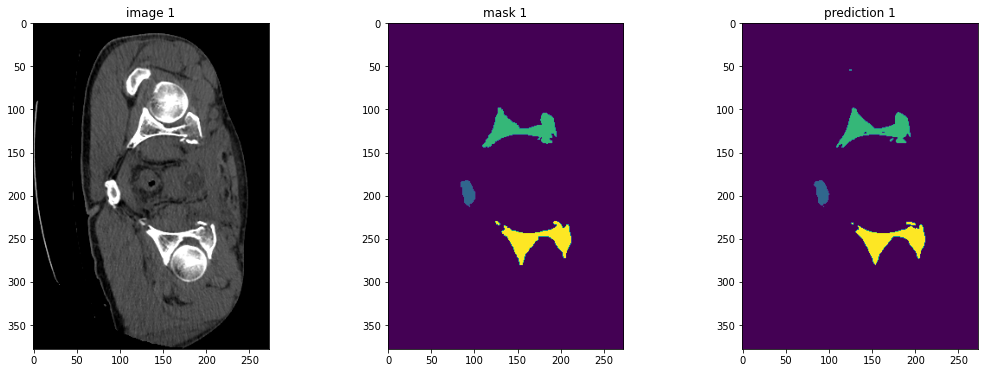

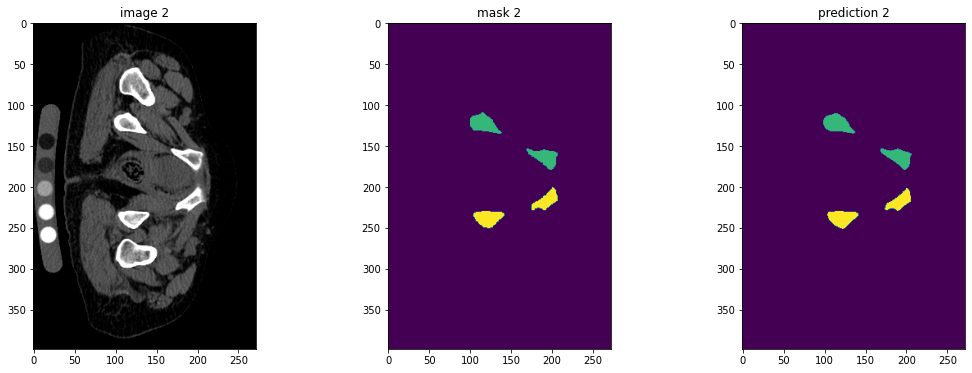

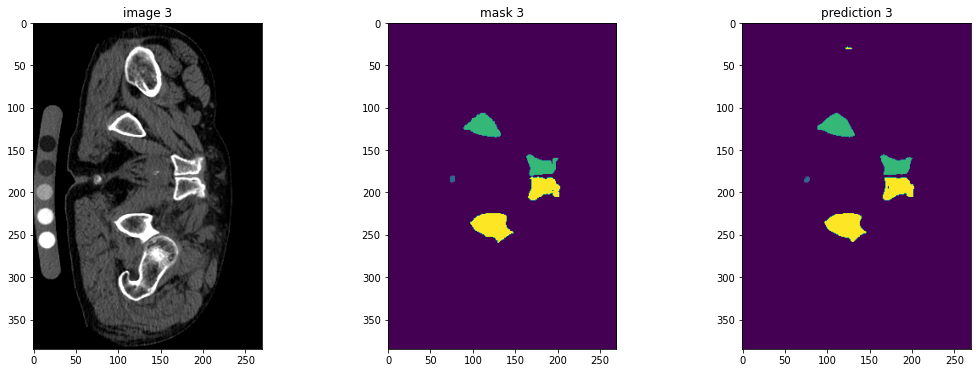

In [19]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        
        val_inputs = val_data["image"].to(device)
        val_outputs = inference(val_inputs)
        
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        
        plt.subplot(1, 3, 2)
        plt.title(f"mask {i}")
        plt.imshow(val_data["mask"][0, 0, :, :, 80])
        
        plt.subplot(1, 3, 3)
        plt.title(f"prediction {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        
        plt.show()
        if i == 3:
            break

In [ ]:
#convert the one hot data into the single channel format first and then draw it (matplotlib)

## Evaluation of Model on original image spacing

In [26]:
test_image = os.path.join(root_dir, 'test_images')
test_mask = os.path.join(root_dir, 'test_masks')

In [27]:
test_images = sorted(glob.glob(os.path.join(test_image, "*data.nii.gz")))
test_labels = sorted(glob.glob(os.path.join(test_mask , "*mask_4label.nii.gz")))

test_dicts = [ {"image": image_name, "mask": label_name} for image_name, label_name in zip(test_images, test_labels) ]
test_files = test_dicts[:]

In [28]:
test_transforms = Compose([
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "mask"]),
    ])


In [29]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader  = DataLoader(test_ds, batch_size=1, num_workers=0)

# test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=0)
# test_loader = DataLoader(test_ds, batch_size=1, num_workers=0)

In [30]:
post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(keys="pred", transform=test_transforms, orig_keys="image", meta_keys="pred_meta_dict", 
            orig_meta_keys="image_meta_dict", meta_key_postfix="meta_dict", nearest_interp=False,to_tensor=True,),
    AsDiscreted(keys="pred", argmax=True, to_onehot=5),
    AsDiscreted(keys="mask", to_onehot=5),
])

In [31]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

model.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model,sw_device="cuda:0", device="cpu")
        #uses cuda to run network(window_data) and uses cpu memory to store the final predicted volume
        
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_outputs, test_labels = from_engine(["pred", "mask"])(test_data)
        
        # compute metric for current iteration
        dice_metric(y_pred=test_outputs, y=test_labels)

    # aggregate the final mean dice result
    metric_test = dice_metric.aggregate().item()
    # reset the status for next validation round
    #dice_metric.reset()

print("Metric on original image spacing: ", metric_test)

#test_data["pred"] = inference(test_inputs)


Metric on original image spacing:  0.9586651921272278


In [32]:
print(dice_metric(y_pred=test_outputs, y=test_labels)) #each individual score

tensor([[0.9525, 0.9726, 0.9845, 0.9782]])


In [33]:
dice_metric.get_buffer() #check all calculated scores

tensor([[0.9041, 0.9717, 0.9807, 0.9075],
        [0.9443, 0.9552, 0.9536, 0.9376],
        [0.9721, 0.9837, 0.9757, 0.9751],
        [0.9434, 0.9579, 0.9643, 0.9585],
        [0.9525, 0.9726, 0.9845, 0.9782],
        [0.9525, 0.9726, 0.9845, 0.9782]])

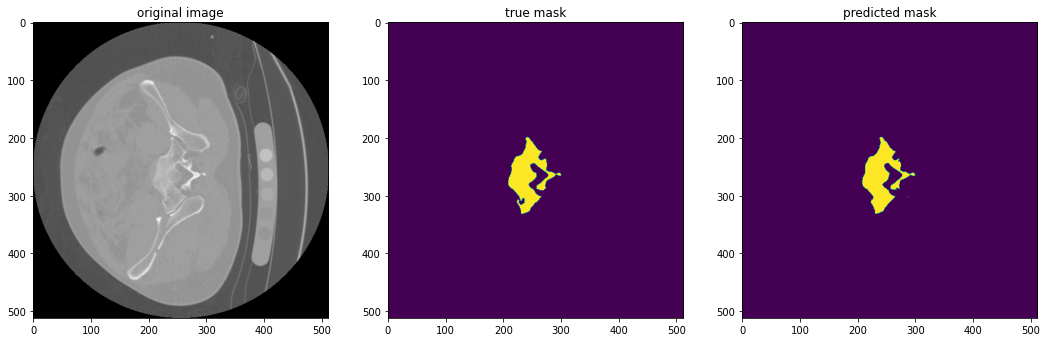

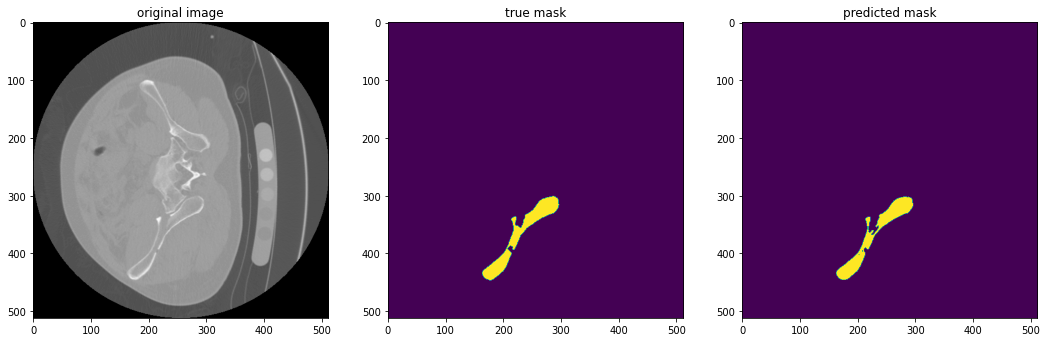

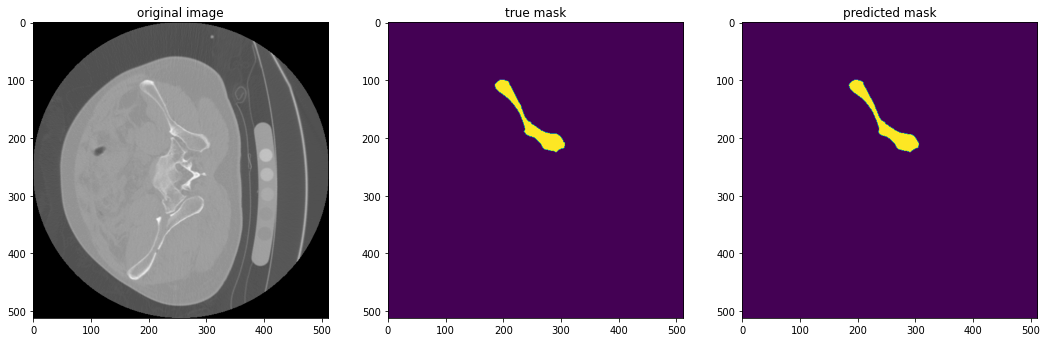

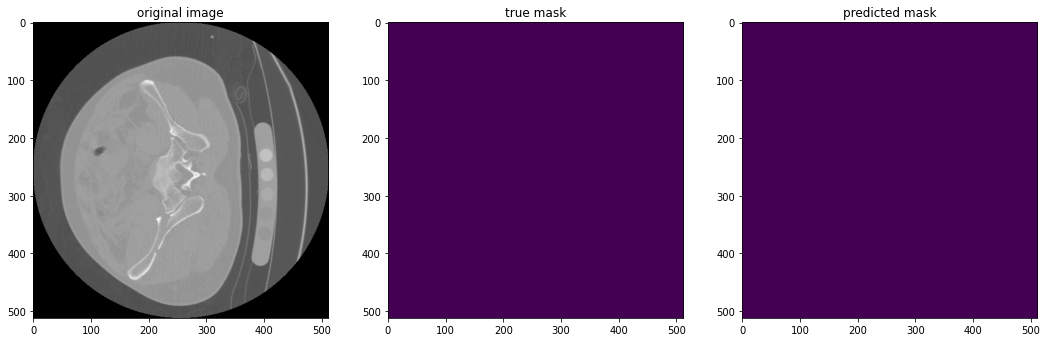

In [34]:
from monai.transforms import LoadImage
loader = LoadImage()
original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

for cls in range(1, 5):
    plt.figure("check", (18, 6))  
    plt.subplot(1, 3, 1)
    plt.title(f"original image")
    plt.imshow(original_image[:, :, 250], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"true mask")
    plt.imshow(test_labels[0].detach().cpu()[cls, :, :, 250])
    plt.subplot(1, 3, 3)
    plt.title(f"predicted mask")
    plt.imshow(test_outputs[0].detach().cpu()[cls, :, :, 250])
    plt.show() 

In [ ]:
#convert the one hot data into the single channel format first and then draw it (matplotlib)

In [ ]:
"""
0: background,
1: sacrum,
2: right_hip,
3: left_hip,
4: lumbar_vertebra.        
""" 

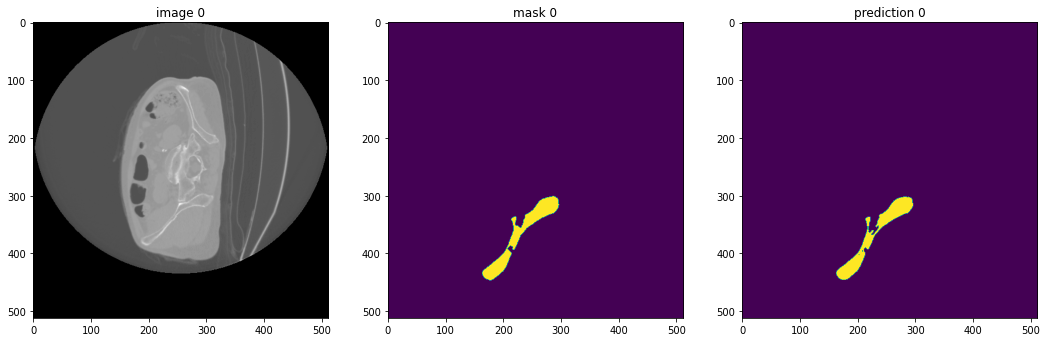

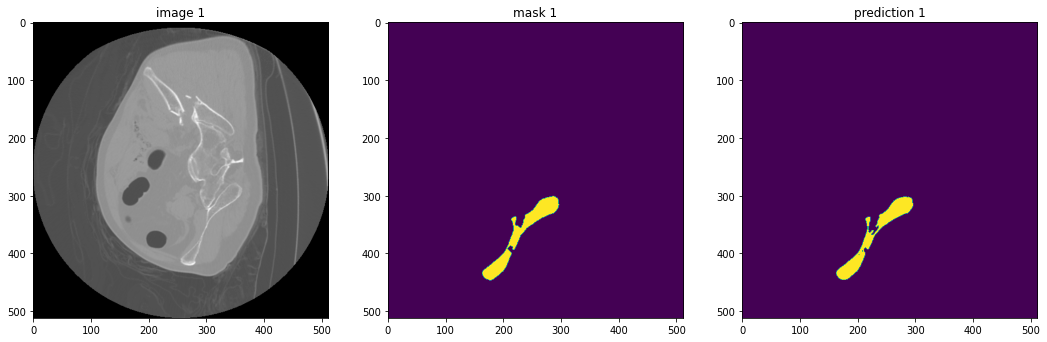

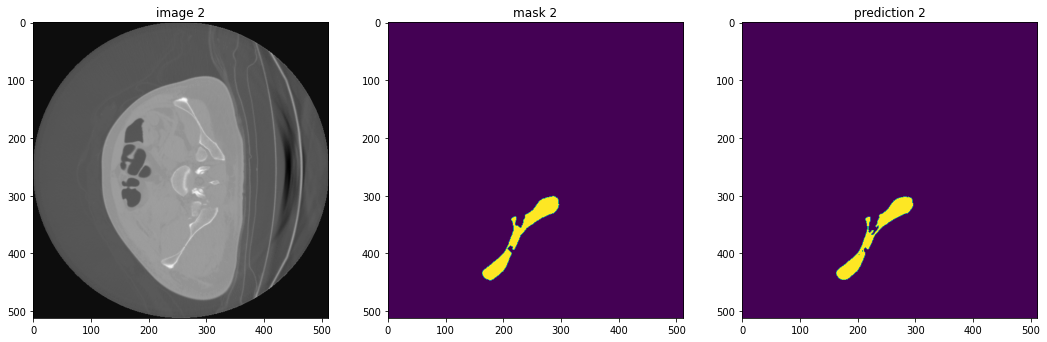

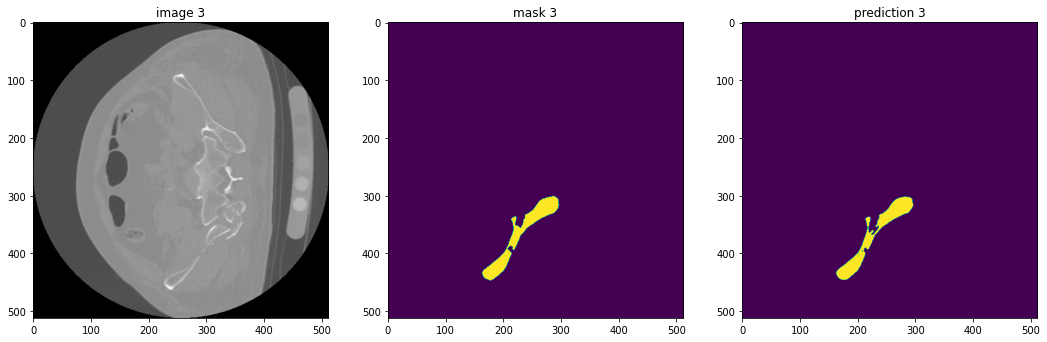

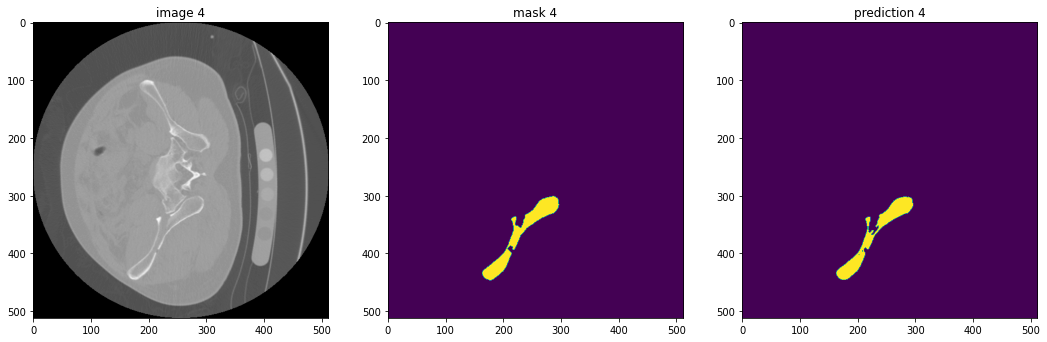

In [51]:
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        loader = LoadImage()
        original_image = loader(test_data["image_meta_dict"]["filename_or_obj"])[0]
        
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(original_image[:, :, 250], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"mask {i}")
        plt.imshow(test_labels[0].detach().cpu()[2, :, :, 250])
        plt.subplot(1, 3, 3)
        plt.title(f"prediction {i}")
        plt.imshow(test_outputs[0].detach().cpu()[2, :, :, 250])
        plt.show()
        if i == 4:
            break

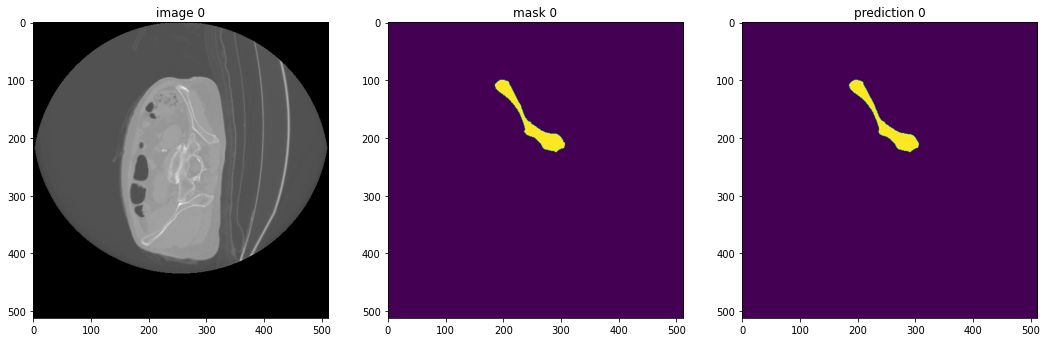

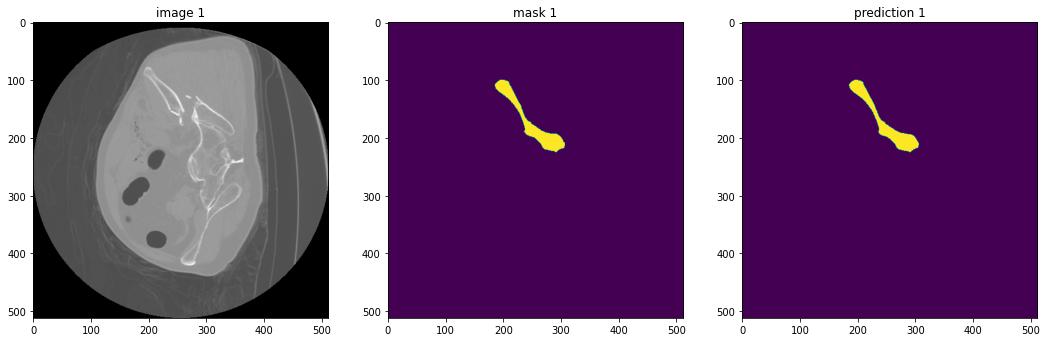

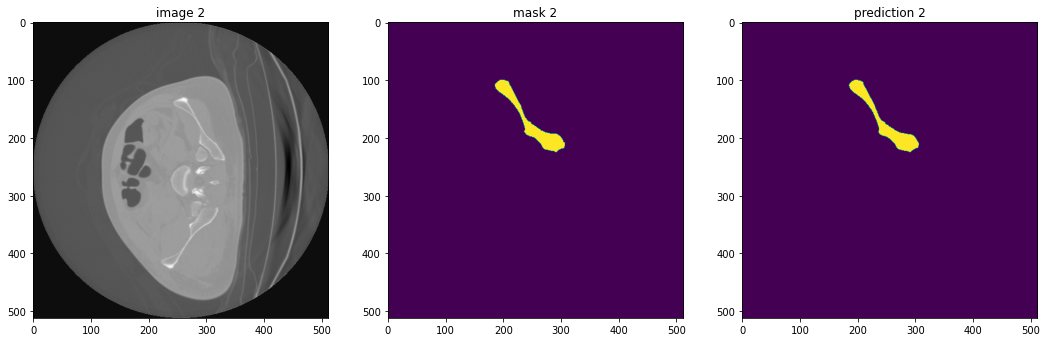

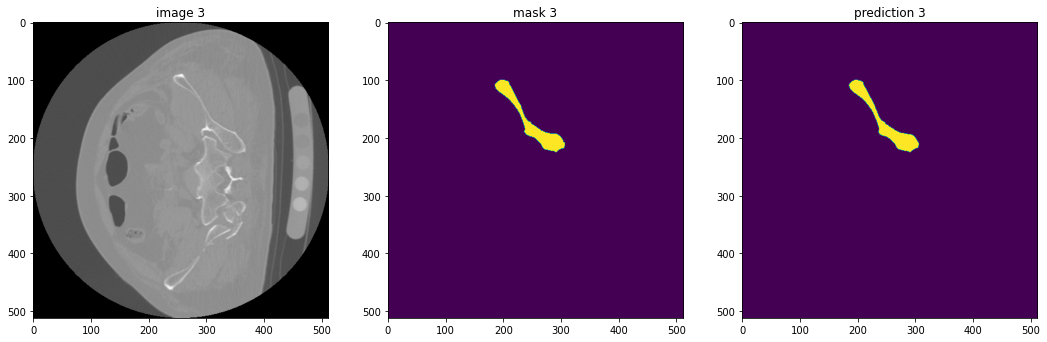

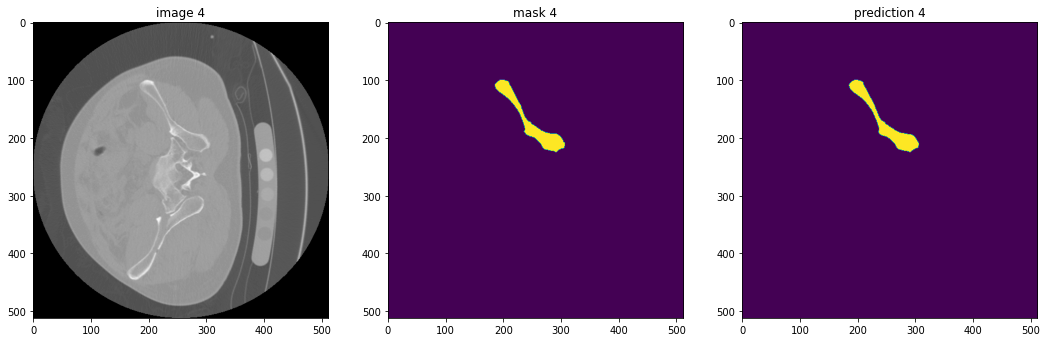

In [52]:
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        loader = LoadImage()
        original_image = loader(test_data["image_meta_dict"]["filename_or_obj"])[0]
        
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(original_image[:, :, 250], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"mask {i}")
        plt.imshow(test_labels[0].detach().cpu()[3, :, :, 250])
        plt.subplot(1, 3, 3)
        plt.title(f"prediction {i}")
        plt.imshow(test_outputs[0].detach().cpu()[3, :, :, 250])
        plt.show()
        if i == 4:
            break